# Bagging and Random Forests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as scs

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

from sklearn.datasets import load_breast_cancer, load_iris, load_boston
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


# my own implementation of partial dependence and
# permutation importance. 
# OOB permutation importance required me to write 
# my own Random Forest class as well
from importance_and_dependence import (MyRandomForestClassifier,
                                       MyRandomForestRegressor,
                                       my_oob_permutation_importance,
                                       partial_dependence,
                                       partial_dependence_2d)

## Objectives
 * Explain the relationship and difference between bagging and a random forest.
 * Explain why bagging/random forests are more accurate than a single decision tree.
 * Explain & construct a random forest (classification or regression).
 * Get feature importances from a random forest.
 * Explain how OOB error is calculated and what it estimates.

## What is an Ensemble Method?

In general, an **ensemble** method combines the output of many models into one, better model. We train multiple *different* models on the data. They could be trained on different subsets of the data, or trained in different ways, or even be completely different types of models.

Once we've done that, we need to combine the models to form a single model.

Class discussion: how would get a single prediction from an ensemble of **regression** models?

Class discussion: how would get a single prediction from an ensemble of **classification** models?



## Ensembles: Intuition

Suppose we have 5 *independent* hard binary classifers (they only output 0 or 1). If each has a 70% probability of correctly classifying a data point, what is the probability that an *ensemble* of these models correctly classifies a point? The ensemble prediction is just the majority vote of the individual classifiers.

Question: what does independent mean?

In [2]:
def find_ensemble_probability(n, p):
    '''Given a n independent classifiers each with
    probability p of voting correctly, return the 
    probability that the majority of the classifiers 
    vote correctly'''
    return (1 - scs.distributions.binom(n,p).cdf(n//2))

In [3]:
find_ensemble_probability(5, 0.7)

0.8369199999999999

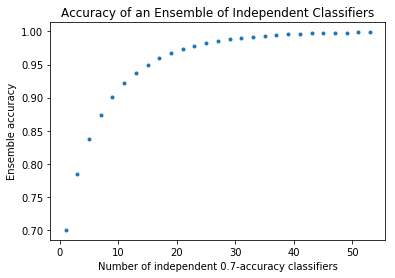

In [4]:
ns = np.arange(1, 55, 2)
ensemble_accuracies = [find_ensemble_probability(n, 0.7) for n in ns]

fig, ax = plt.subplots()
ax.plot(ns, ensemble_accuracies, '.')
ax.set_ylabel("Ensemble accuracy")
ax.set_xlabel("Number of independent 0.7-accuracy classifiers")
ax.set_title("Accuracy of an Ensemble of Independent Classifiers");

$$ \binom{5}{5} 0.7^5 + \binom{5}{4} 0.7^4 0.3 + \binom{5}{3} 0.7^3 0.3^2 \approx 0.83 $$

With 55 such classifiers we can achieve 99.9% accuracy.


Question: what's the limitation?

## How do we get a bunch of independent models?

If the models are all identical, ensembles don't help. What can we do?

Train each model on different subset of data.

Question: Why is this better than a single good model?

## Bias and Variance

Question: what is bias?

Question: what is variance?

Question: what is the bias of an unpruned decision tree?

## Review: Bootstrapping

What is a bootstrap sample?

What have we learned that bootstrap samples are good for so far?

Let's get the median of some data.

In [7]:
data = scs.uniform(0,10).rvs(100)
np.median(data)

4.4258315960709655

What's the confidence interval of this estimate?

In [8]:
def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.)))

In [9]:
alpha = .05
ci = bootstrap_confidence_interval(data, np.median, alpha)

print("The {}% confidence interval is from {} to {}".format(1-alpha, *ci))

The 0.95% confidence interval is from 3.624740492729741 to 5.617771323507796


Our procedure was
  * Take 1000 bootstrap samples.
  * Take the median of each sample.
  * The 95% confidence interval for the median is between the 25th and 975th largest samples.
  
To confirm this worked, let's do it a bunch of times.

In [10]:
hits = []
for _ in range(100):
    data = scs.uniform(0,10).rvs(100)
    ci = bootstrap_confidence_interval(data, np.median)
    hits.append(ci[0] < 5.0 and ci[1] > 5.0)
print(np.mean(hits))

0.93


This is the fraction of time the bootstrapped CI contained the true median

## Bootstrapped aggregation

 * We are thinking about the population of all possible decision tree models on our data.
 * If I take $n$ samples *iid* from this distribution and average them the variance goes down by $\sqrt n$
 * There is some correlation between models because they are all trained on bootstrap samples from the same draw.

## An Experiment

You're each going to be a decision tree on some data based on a bootstrap sample, and then we'll all ensemble the results.

In [11]:
data = load_iris()

# Split into test/train, using the same random state for everyone
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=462)

In [12]:
clf = DecisionTreeClassifier()
# each of you has a different bootstrap sample
indices = np.arange(len(X_train))
bootstrap_sample_indices = np.random.choice(indices, len(X_train))
clf.fit(X_train[bootstrap_sample_indices], y_train[bootstrap_sample_indices])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))

Accuracy = 0.895


In [14]:
print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

My prediction: [0 2 0 2 2 1 2 2 0 2 2 0 2 2 2 2 1 2 1 0]
Actual result: [0 2 0 1 2 1 2 2 0 2 2 0 1 2 2 2 1 2 1 0]


What is your prediction?

This concept, creating each model from a bootstrap sample and aggregating the results, is called **bagging**. It can be used with any sort of model, but is generally done with decision trees.

Question: why?

### Bootstrapping on Regression Trees

Let's do another example. Consider some points.

In [15]:
n_data = 5000
x = scs.uniform(0, 10).rvs(n_data)
y = np.sin(x) + scs.norm(0, 0.5).rvs(n_data)

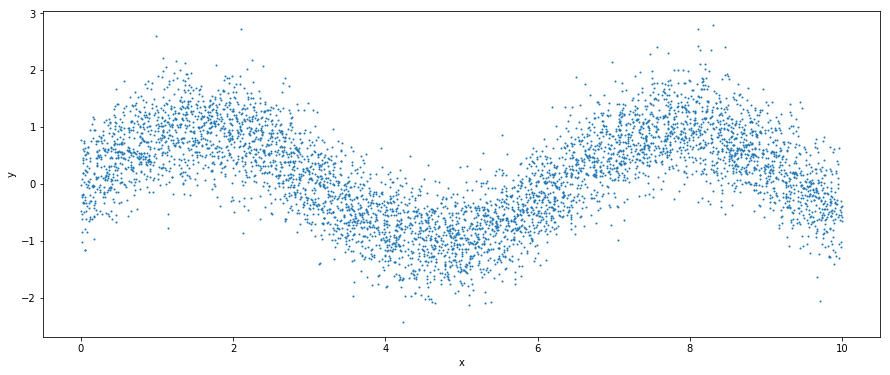

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
ax.set_xlabel('x')
ax.set_ylabel('y');

We'll create a decision tree to predict the points. We won't make it that deep because we want to visualize the prediction.

In [17]:
max_depth = 7
model0 = DecisionTreeRegressor(max_depth=max_depth)
model0.fit(x.reshape(-1, 1), y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

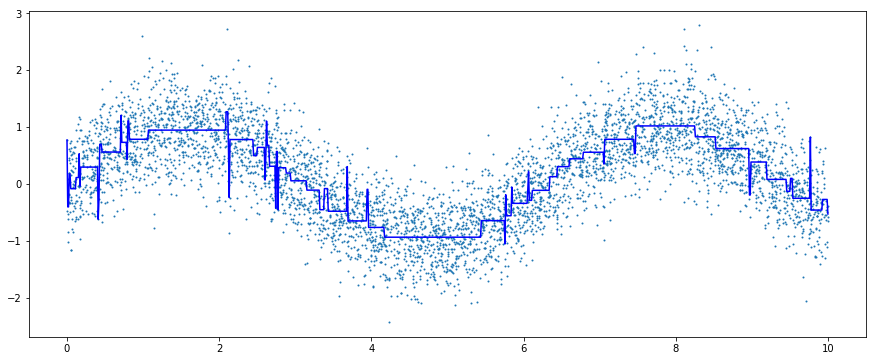

In [18]:
n_pts = 1000
xpts = np.linspace(0, 10, n_pts)

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)

ax.plot(xpts, model0.predict(xpts.reshape(-1, 1)), 'b');

That's what one decision tree looks like; each discontinuity is a node split. What if we create a bunch of bootstrap samples and build an ensemble of trees from them?

In [19]:
n_bootstraps = 5000
yptses = np.zeros((n_bootstraps, n_pts))
for i in range(n_bootstraps):
    bootstrap = np.random.choice(np.arange(n_data), n_data, replace=True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x[bootstrap].reshape(-1, 1), y[bootstrap])
    yptses[i] = model.predict(xpts.reshape(-1, 1))


Here are three of the bootstrapped trees:

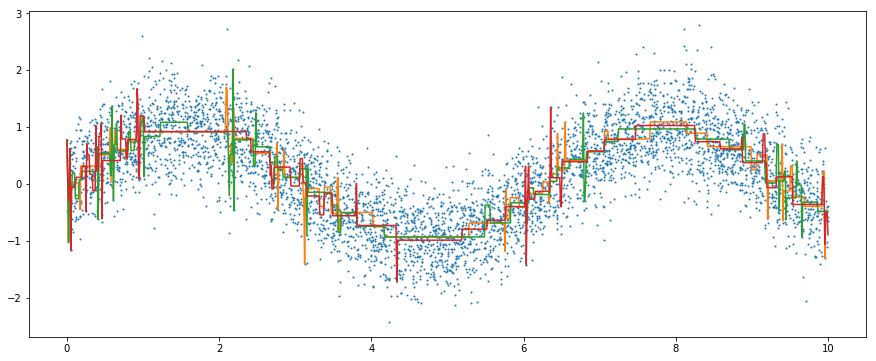

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)

for i in range(3):
    ax.plot(xpts, yptses[i]);

And here in black is the average across all bootstrapped trees:

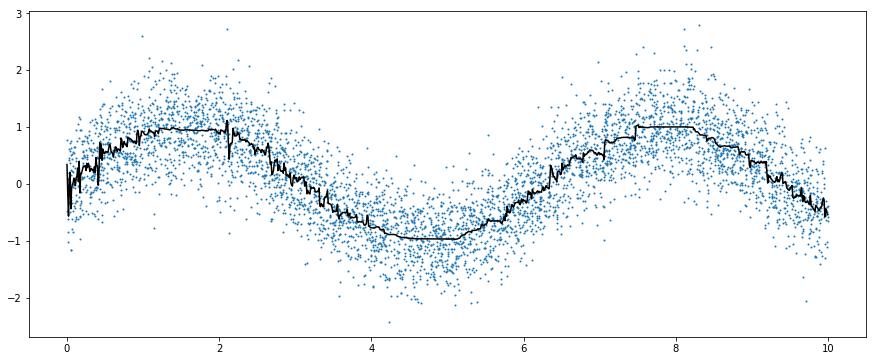

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)

ax.plot(xpts, yptses.mean(axis=0), 'k');

## Random Forests

Bagging decision trees is pretty cool, but the trees still tend to look pretty similar. We want a way to make the trees more different (decorrelate them) without substantially increasing the bias of each tree.

Random forests do this with **feature subsetting** (also called "subspace sampling"). For any node in any tree, instead of finding the best split among **all** features, we randomly select a few features, and find the best split among just those features. The number of features $m$ to consider at each split is a hyperparameter; typically $m = \sqrt k$ is used.

Again, the features to consider are chosen **at each split**, not each tree. **Everyone gets this wrong.**

For example, suppose we're building a model with nine features. One of them is really predictive, another is pretty good, and the others are just ok.

If we build an ensemble of bagged trees, probably each will use the good feature as the first split, and probably each will use the pretty-good feature at the next split. For the other splits the trees might differ, particularly farther down when only a few points are being considered, but the first branches will be pretty much the same (even though the trees are getting slightly different sets of data).

If we build a tree in a random forest, that first split will only consider three (random) features. Only a fraction of the trees (around 30%) will consider the "good" feature on the first split, so they will use that. Some of the others will consider the "pretty-good" feature, so they will start there. The others will start at some other feature. Those trees will still consider the good and pretty-good features at some of the lower nodes (randomly), and will get to take advantage of them, but the overall structure of those trees will be very different.

## Random Forest Parameters

Random Forest Parameters

 * Total number of trees
 * Number of features to use at each split
 * Individual decision tree Parameters
    - e.g., tree depth, pruning, split criterion

In general, RF are fairly robust to the choice of parameters and overfitting.

## Pros and Cons of Random Forest

Pros

 * Often give near state-of-the-art performance
 * Good out-of-the-box performance
 * No feature scaling needed
 * Model nonlinear relationships

Cons

 * Can be expensive to train (though can be done in parallel)
 * Requires some work to interpret the effect of a single feature / feature interaction on the target

## Performance

Let's investigate how well a random forest performs compared with a single decision tree using the breast cancer dataset. 

In [22]:
# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# dropping these very informative features to illustrate
#  the performance difference between RF and a single tree
X = X.drop(['worst concave points', 'mean concave points', 
            'worst perimeter', 'worst radius', 
            'worst area', 'mean concavity'], axis=1)

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)


In [23]:
X_train.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'perimeter error', 'area error', 'smoothness error',
       'compactness error', 'concavity error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst texture',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [24]:
y_train[:10]

56     0
144    1
60     1
6      0
8      0
474    1
320    1
252    0
202    0
246    1
dtype: int64

In [25]:
y_train.mean()

0.6194225721784777

First, consider a decision tree, doing a grid search over hyperparameters.

In [26]:
# Parameter Search                                     
model = DecisionTreeClassifier()
depth_param = np.arange(1, 12, 1)
num_samples_param = np.arange(5,95,10)
parameters = {'max_depth' : depth_param,
             'min_samples_leaf' : num_samples_param}
clf = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
clf.fit(X_train,y_train)
print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: 0.894


In [27]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
clf.best_params_

{'max_depth': 2, 'min_samples_leaf': 5}

Now random forests.

In [29]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

Accuracy score: 0.952


So that's better.

# Interpreting Random Forests

## Review: Bagging and Random Forests

What is bagging?

Can bagging be used with other models?

What's the difference between bagging and random forests?

## Out-Of-Bag Error

The out-of-bag error is a way to measure the error of a bagged model (including random forests).

Since the decision trees are constructed from a bootstrapped sample, each tree will (probably) not see all of the data, so each data point will (probably) not be seen by many of the trees.

Let's imagine a data set with 10 points, and that we're making a random forest with 20 trees. We'll then construct 20 bootstrap samples.

In [30]:
fake_data = np.random.random(10)

n_data = len(fake_data)
n_trees = 20

np.random.seed(42)

bootstrap_indices = np.random.choice(n_data,
                                     [n_trees, n_data],
                                     replace=True)
# sort along rows to make it a bit easier to read
bootstrap_indices.sort(axis=1)
bootstrap_indices

array([[2, 3, 4, 4, 6, 6, 6, 7, 7, 9],
       [1, 1, 2, 3, 4, 5, 5, 7, 7, 7],
       [0, 0, 2, 3, 4, 5, 6, 8, 9, 9],
       [1, 2, 2, 3, 4, 4, 6, 6, 8, 8],
       [1, 1, 3, 4, 6, 7, 8, 8, 9, 9],
       [0, 1, 1, 2, 3, 3, 5, 5, 7, 9],
       [1, 1, 3, 3, 5, 6, 7, 8, 9, 9],
       [0, 1, 4, 4, 7, 7, 8, 8, 8, 9],
       [0, 0, 2, 2, 6, 7, 7, 7, 7, 8],
       [0, 2, 4, 6, 6, 7, 8, 8, 9, 9],
       [0, 1, 2, 2, 4, 5, 6, 6, 7, 7],
       [0, 0, 2, 2, 4, 4, 6, 6, 8, 9],
       [0, 2, 3, 3, 4, 6, 6, 6, 9, 9],
       [1, 2, 3, 3, 4, 5, 5, 6, 8, 9],
       [0, 0, 3, 6, 6, 8, 8, 8, 8, 9],
       [0, 2, 2, 4, 5, 6, 7, 7, 8, 9],
       [0, 0, 1, 3, 3, 5, 6, 7, 8, 9],
       [0, 0, 0, 0, 1, 1, 2, 4, 5, 7],
       [0, 0, 1, 2, 4, 4, 5, 6, 6, 9],
       [0, 1, 3, 3, 4, 5, 5, 6, 7, 7]])

We would then construct 20 trees, each using the data in one of the rows.

Notice the first tree (and several others) isn't constructed using point 0 at all. So we could test that point of an ensemble of just those trees a get a independent measure of the effectiveness of the model. Simililarly, we could test other points on other trees.

Question: which trees would we use to test point 1?



In [31]:
bootstrap_indices[(bootstrap_indices != 1).all(axis=1), :]

array([[2, 3, 4, 4, 6, 6, 6, 7, 7, 9],
       [0, 0, 2, 3, 4, 5, 6, 8, 9, 9],
       [0, 0, 2, 2, 6, 7, 7, 7, 7, 8],
       [0, 2, 4, 6, 6, 7, 8, 8, 9, 9],
       [0, 0, 2, 2, 4, 4, 6, 6, 8, 9],
       [0, 2, 3, 3, 4, 6, 6, 6, 9, 9],
       [0, 0, 3, 6, 6, 8, 8, 8, 8, 9],
       [0, 2, 2, 4, 5, 6, 7, 7, 8, 9]])

In [32]:
bootstrap_indices[(bootstrap_indices != 1).all(axis=1)]

array([[2, 3, 4, 4, 6, 6, 6, 7, 7, 9],
       [0, 0, 2, 3, 4, 5, 6, 8, 9, 9],
       [0, 0, 2, 2, 6, 7, 7, 7, 7, 8],
       [0, 2, 4, 6, 6, 7, 8, 8, 9, 9],
       [0, 0, 2, 2, 4, 4, 6, 6, 8, 9],
       [0, 2, 3, 3, 4, 6, 6, 6, 9, 9],
       [0, 0, 3, 6, 6, 8, 8, 8, 8, 9],
       [0, 2, 2, 4, 5, 6, 7, 7, 8, 9]])

On average, how many trees can we use to test each point?

In [33]:
bsize = []
for i in range(10):
    bsize.append(sum((bootstrap_indices != i).all(axis=1)))

In [34]:
np.mean(bsize)/n_trees

0.335

It turns out this number is $\frac{1}{e}$; you can [read about the math](https://stats.stackexchange.com/questions/88980/why-on-average-does-each-bootstrap-sample-contain-roughly-two-thirds-of-observat) and, relatedly, [derangements](https://en.wikipedia.org/wiki/Derangement)

The **out of bag (OOB) error** for a single tree is the error on the unseen data points. The OOB error for the forest is the average OOB error of the trees. 


OOB error gives an estimate of the generalization error of our model, but often we use cross validation anyway because we're comparing with other models and we want to use the same validation pipeline for everything.

## Feature Importances

One of the challenges of random forests is the lack of interpretability. Feature importances are a measure of (roughly) which features made the most effective decisions across the trees.

This can be a critical business question. For example, with churn analysis, it's generally more important to understand *why* customers are churning than to predict which customers are going to churn.

How should we measure it?

## Feature Importances: Average Decrease in Impurity

How much does each feature decrease the impurity? (Described [here](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp))

 * For each tree, each split is made in order to reduce the total impurity of the tree (Gini/entropy/MSE). 
 * "Total information gain" for a single tree is the sum of the information gain at each split, and a feature's importance for a single tree is the total information gain of splits involving that feature divided by the total information gain of the tree.
 * This is called **Gini importance** and it is how `sklearn` calculates feature importance. 
 * The importance of a feature in a forest is the average of the Gini importances for that feature across all trees. 

In [35]:
# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [36]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [37]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [38]:
rf.oob_score_

0.9553805774278216

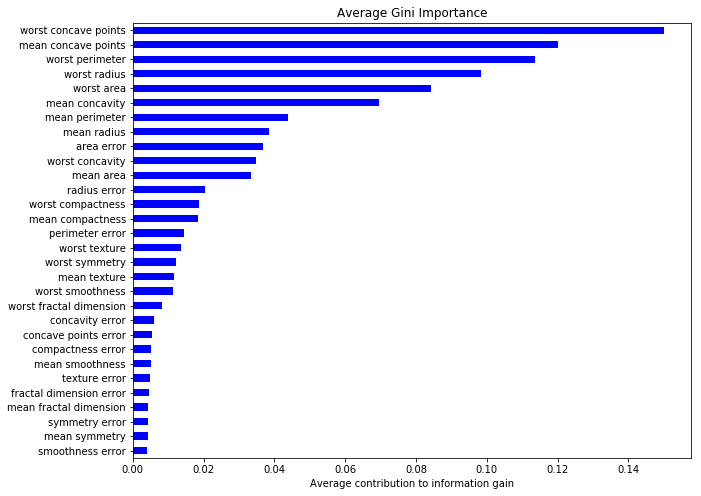

In [40]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

## Feature Importances: Average Decrease in Accuracy when a feature's values are shuffled

(Described [here](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp))

How much does randomly shuffling the values of a feature affect accuracy?

To compute the importance of the $j^{th}$ feature:

 * When the $b^{th}$ tree is grown, use it to predict the OOB samples and record accuracy.
 * Scramble the values of the $j^{th}$ feature in the OOB samples and do the prediction again.  Compute the new (lower) accuracy.
 * Average the decrease in accuracy across all trees.

Here we have to roll our own random forest since `sklearn`s `RandomForest` class doesn't give us easy access to the OOB sample indices. See the code in `importance_and_dependence.py`.

In [41]:
# Load data
data = load_breast_cancer()
X = data.data
y = data.target

feature_names = data.feature_names

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [42]:
# My random forest implementation only takes numpy arrays,
# not pandas dataframes. Sorry!

myrf = MyRandomForestClassifier(n_trees=1000)
myrf.fit(X_train, y_train)

In [43]:
myrf.n_classes

2

In [44]:
confusion_matrix(y_test, myrf.predict(X_test))

array([[ 61,   6],
       [  4, 117]])

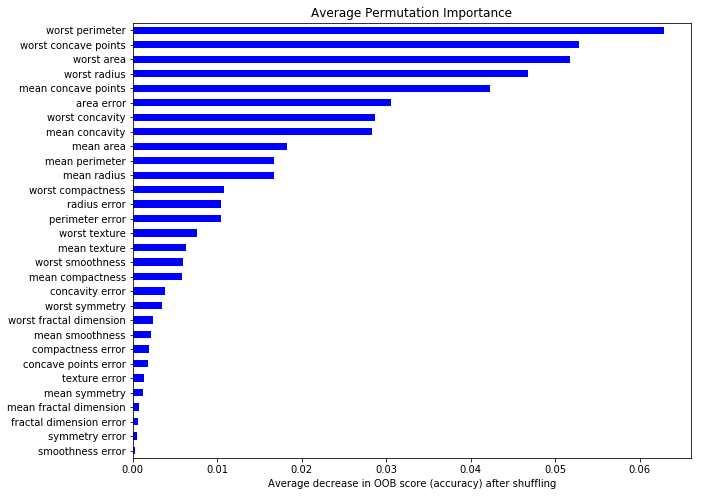

In [45]:
my_feat_importance = my_oob_permutation_importance(myrf, X_train, y_train)

importance_series = pd.Series(data=my_feat_importance, index=feature_names)
ax = importance_series.sort_values().plot(kind='barh', 
                                          figsize=(10,8),
                                          color='b')
ax.set_title('Average Permutation Importance')
ax.set_xlabel('Average decrease in OOB score (accuracy) after shuffling');

In [ ]:
accuracy_sco

### Warning: "feature importance" is a misleading name.
It gets tremendously overinterpreted. See this article about how to treat these values:
http://explained.ai/rf-importance/index.html

Also, "feature importance" tells us nothing about the directional relationship with the target. For that, let's turn to "partial dependence".

# Partial Dependence plots

http://scikit-learn.org/stable/modules/ensemble.html#partial-dependence

Here's a rough overview of how to calculate the _partial dependence_ of the model $\hat{y} = \hat{f}(\vec{x})$ on a particular feature $k$.

- (assume you've already fit a model $\hat{f}(\vec{x})$ on a data set $X$)
- replace column $k$ of the data with a value $z$. Let's call a point modified in this way $\vec{x}'$
- use your model to predict on this modified data: $\hat{f}(\vec{x_i}')$ for all $i$
- take the average of these predictions (the raw predictions for regression, or the log of the odds using the predicted probability for classification). This is the partial dependence of $\hat{y}$ on feature $k$ evaluated at $z$. Let's call this function $\text{PDP}(z)$
  - $\text{PDP}(z) = \frac{1}{n}\sum_i^n \hat{f}(\vec{x_i}'; x_{ik}=z)$
- plot $\text{PDP}(z)$ as $z$ ranges over the observed values of $X_k$


### Classification example: breast cancer data

In [44]:
# Load data
data = load_breast_cancer()
X = data.data
y = data.target

feature_names = data.feature_names

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [45]:
model = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

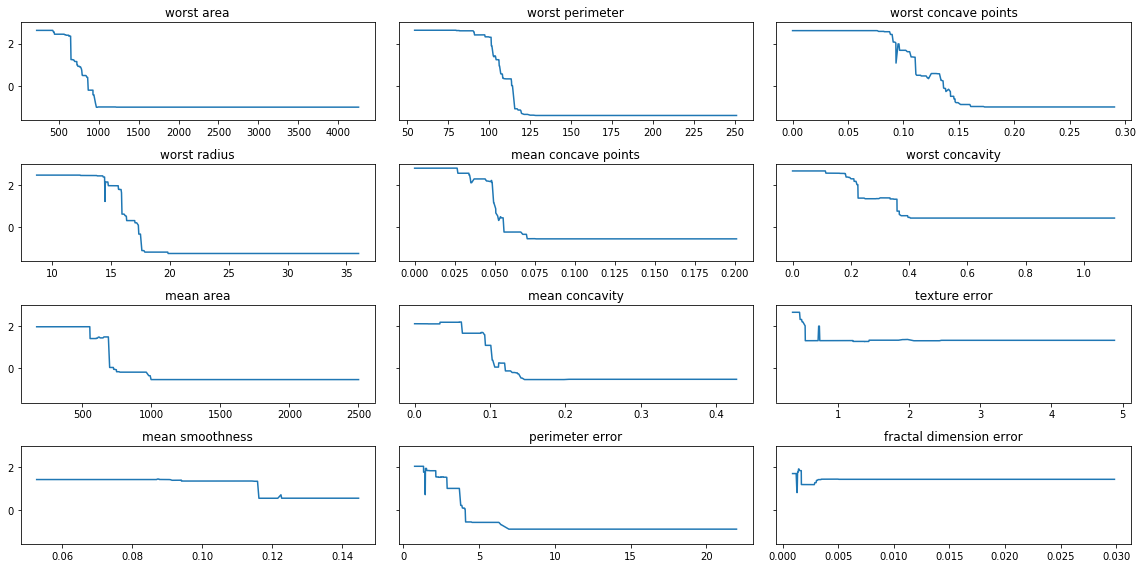

In [46]:
feature_indices = [23, 22, 27, 20, 7, 26, 3, 6, 11, 4, 12, 19]

fig, axes = plt.subplots(4,3, figsize=(16,8), sharey=True)

for ax, feat_ind in zip(axes.flatten(), feature_indices):
    xx, pdp = partial_dependence(model, X_train, feat_ind)
    ax.plot(xx, pdp)
    ax.set_title(feature_names[feat_ind])
plt.tight_layout()

### Regression example: boston housing prices

In [47]:
boston = load_boston()
boston_X, boston_y, boston_names = boston['data'], boston['target'], boston['feature_names']

b_X_train, b_X_test, b_y_train, b_y_test = train_test_split(boston_X, boston_y, test_size=0.25, random_state=1)

In [48]:
boston_X.shape

(506, 13)

In [49]:
model2 = RandomForestRegressor(n_estimators=50,
                           max_features='auto',
                           random_state=0)
model2.fit(b_X_train, b_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

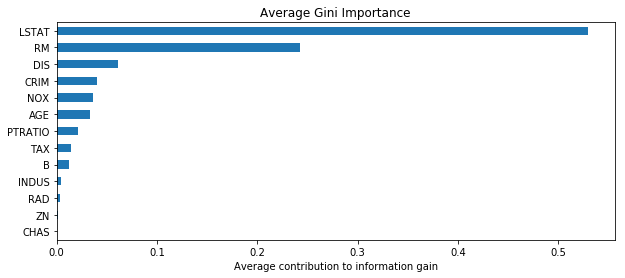

In [50]:
# Plot the feature importance
b_feat_scores = pd.Series(model2.feature_importances_,
                           index=boston_names)
b_feat_scores = b_feat_scores.sort_values()
ax = b_feat_scores.plot(kind='barh', figsize=(10,4))
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)

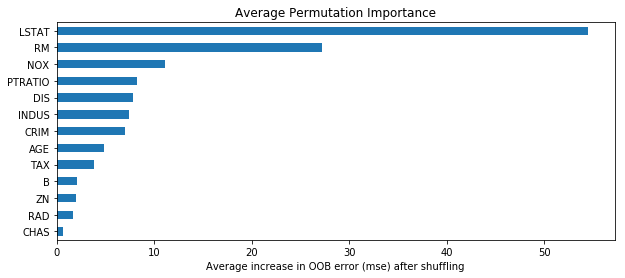

In [53]:
model3 = MyRandomForestRegressor(n_trees=200)
model3.fit(b_X_train, b_y_train)
perm_feat_imp = my_oob_permutation_importance(model3, b_X_train, b_y_train, scorer=neg_mse)

perm_importance_series = pd.Series(data=perm_feat_imp, index=boston_names)
ax = perm_importance_series.sort_values().plot(kind='barh', figsize=(10,4))
ax.set_title('Average Permutation Importance')
ax.set_xlabel('Average increase in OOB error (mse) after shuffling');

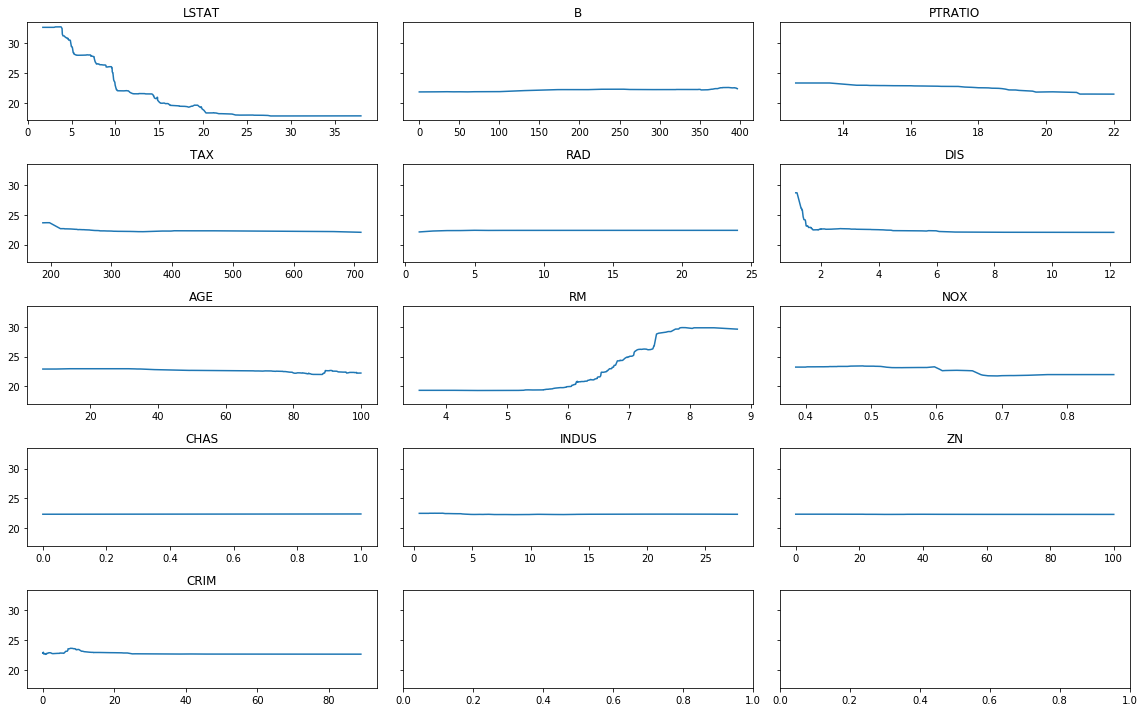

In [54]:
fig, axes = plt.subplots(5,3, figsize=(16,10), sharey=True)

for ax, feat_ind in zip(axes.flatten(), reversed(range(boston_X.shape[1]))):
    xx, pdp = partial_dependence(model2, b_X_train, feat_ind, classification=False)
    ax.plot(xx, pdp)
    ax.set_title(boston_names[feat_ind])
plt.tight_layout()

## What about feature interactions? Joint partial dependence?

In [55]:
from mpl_toolkits.mplot3d import Axes3D

In [56]:
xx1, xx2, pdp2d = partial_dependence_2d(model2, b_X_train, 5, 12, classification=False)

In [57]:
xx1.shape

(344, 348)

In [58]:
xx2.shape

(344, 348)

In [59]:
pdp2d.shape

(344, 348)

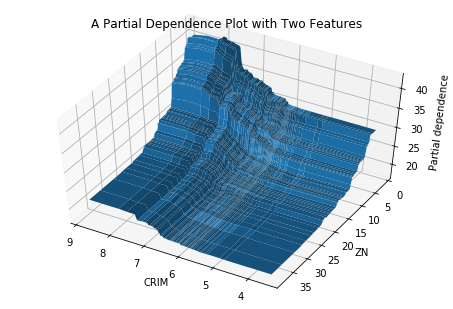

In [60]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(xx1, xx2, pdp2d)
ax.view_init(elev=50, azim=120)
ax.set_xlabel(boston_names[0])
ax.set_ylabel(boston_names[1])
ax.set_zlabel('Partial dependence')
ax.set_title("A Partial Dependence Plot with Two Features");